Record linkage is a powerful technique used to merge multiple datasets together, used when values have typos or different spellings. In this chapter, you'll learn how to link records by calculating the similarity between strings—you’ll then use your new skills to join two restaurant review datasets into one clean master dataset.;

## Comparing strings

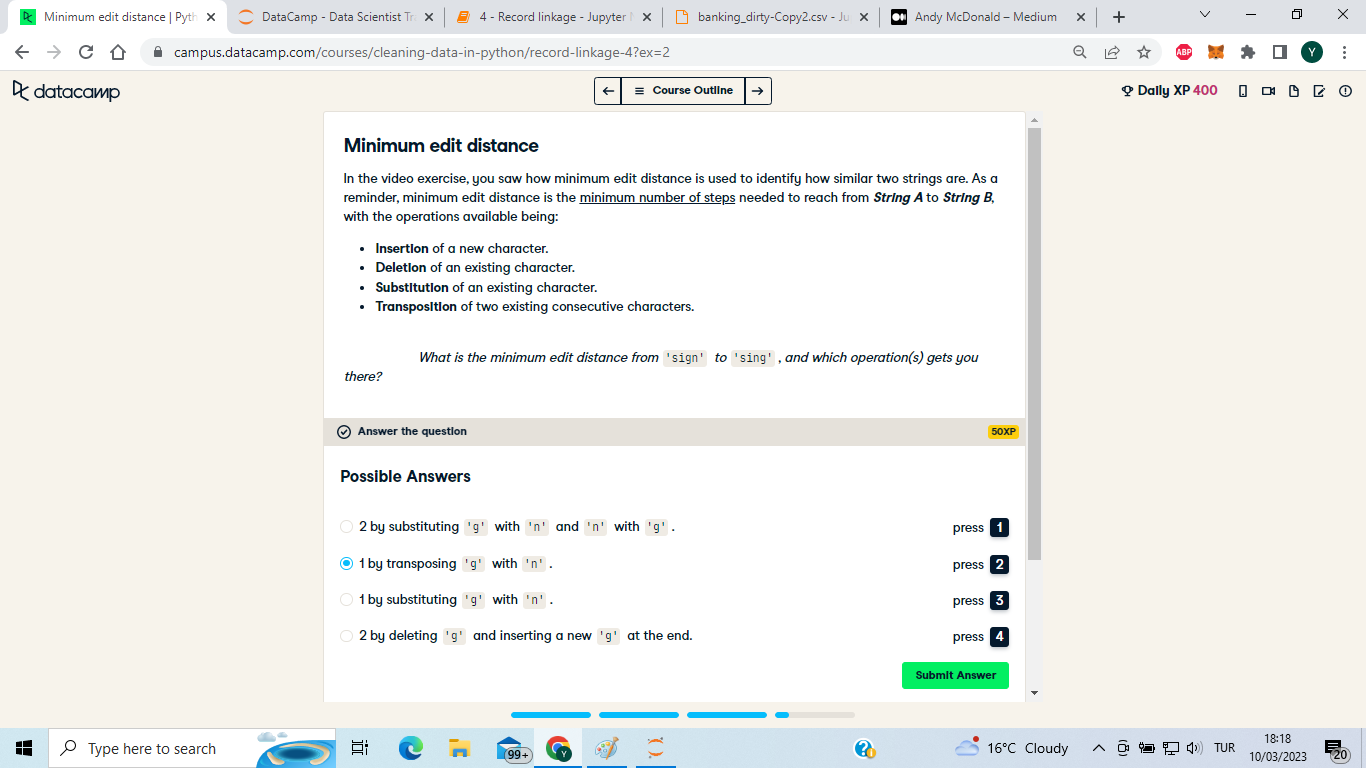

Correct! Transposing the last two letters of 'sign' is the easiest way to get to 'sing' - in the next exercise, you'll use edit distance at scale to remap categories!

#### The cutoff point
In this exercise, and throughout this chapter, you'll be working with the restaurants DataFrame which has data on various restaurants. Your ultimate goal is to create a restaurant recommendation engine, but you need to first clean your data.

This version of restaurants has been collected from many sources, where the cuisine_type column is riddled with typos, and should contain only italian, american and asian cuisine types. There are so many unique categories that remapping them manually isn't scalable, and it's best to use string similarity instead.

Before doing so, you want to establish the cutoff point for the similarity score using the thefuzz's process.extract() function by finding the similarity score of the most distant typo of each category.

In [1]:
from thefuzz import fuzz, process
import pandas as pd
import matplotlib.pyplot as plt

restaurants = pd.read_csv("restaurants_L2.csv")
restaurants

C:\Users\hp\anaconda3\lib\site-packages\thefuzz\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


,Unnamed: 0,name,addr,city,phone,type
0,0,arnie morton's of chicago,435 s. la cienega blv .,los angeles,3102461501,american
1,1,art's delicatessen,12224 ventura blvd.,studio city,8187621221,american
2,2,campanile,624 s. la brea ave.,los angeles,2139381447,american
3,3,fenix,8358 sunset blvd. west,hollywood,2138486677,american
4,4,grill on the alley,9560 dayton way,los angeles,3102760615,american
...,...,...,...,...,...,...
331,331,vivande porta via,2125 fillmore st.,san francisco,4153464430,italian
332,332,vivande ristorante,670 golden gate ave.,san francisco,4156739245,italian
333,333,world wrapps,2257 chestnut st.,san francisco,4155639727,american
334,334,wu kong,101 spear st.,san francisco,4159579300,asian


In [2]:
# Import process from thefuzz
from thefuzz import process

# Store the unique values of cuisine_type in unique_types
unique_types = restaurants["type"].unique()

# Calculate similarity of 'asian' to all values of unique_types
print(process.extract('asian', unique_types, limit = len(unique_types)))

# Calculate similarity of 'american' to all values of unique_types
print(process.extract('american', unique_types, limit = len(unique_types)))

# Calculate similarity of 'italian' to all values of unique_types
print(process.extract('italian', unique_types, limit = len(unique_types)))

[('asian', 100), ('italian', 67), ('american', 62), ('mexican', 50), ('cajun', 40), ('southwestern', 36), ('southern', 31), ('coffeebar', 26), ('steakhouses', 25)]
[('american', 100), ('mexican', 80), ('cajun', 68), ('asian', 62), ('italian', 53), ('southwestern', 41), ('southern', 38), ('coffeebar', 24), ('steakhouses', 21)]
[('italian', 100), ('asian', 67), ('mexican', 43), ('american', 40), ('cajun', 33), ('southern', 27), ('southwestern', 26), ('steakhouses', 26), ('coffeebar', 12)]


#### Question
Take a look at the output, what do you think should be the similarity cutoff point when remapping categories?

<strong>a.80</strong><br>
b.70<br>
c.60

Correct! 80 is that sweet spot where you convert all incorrect typos without remapping incorrect categories. Often times though, you may need to combine the techniques learned in chapter 2, especially since there could be strings that make it beyond our cutoff point, but are not actually a match!

#### Remapping categories II
In the last exercise, you determined that the distance cutoff point for remapping typos of 'american', 'asian', and 'italian' cuisine types stored in the cuisine_type column should be 80.

In this exercise, you're going to put it all together by finding matches with similarity scores equal to or higher than 80 by using fuzywuzzy.process's extract() function, for each correct cuisine type, and replacing these matches with it. Remember, when comparing a string with an array of strings using process.extract(), the output is a list of tuples where each is formatted like:

(closest match, similarity score, index of match)
The restaurants DataFrame is in your environment, and you have access to a categories list containing the correct cuisine types ('italian', 'asian', and 'american').

In [3]:
# Inspect the unique values of the cuisine_type column
print(restaurants["type"].unique())

['american' 'asian' 'italian' 'coffeebar' 'mexican' 'southwestern'
 'steakhouses' 'southern' 'cajun']


In [4]:
# Create a list of matches, comparing 'italian' with the cuisine_type column
matches = process.extract('italian', restaurants['type'], limit=len(restaurants.type))

# Inspect the first 5 matches
print(matches[0:5])

for match in matches:
  # Check whether the similarity score is greater than or equal to 80
  if match[1] >= 80:
    # Select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
    restaurants.loc[restaurants['type'] == match[0]] = 'italian'

[('italian', 100, 6), ('italian', 100, 10), ('italian', 100, 11), ('italian', 100, 16), ('italian', 100, 19)]


In [5]:
categories = ['italian', 'asian', 'american']

# Iterate through categories
for cuisine in categories:  
  # Create a list of matches, comparing cuisine with the cuisine_type column
  matches = process.extract(cuisine, restaurants['type'], limit=len(restaurants.type))

  # Iterate through the list of matches
  for match in matches:
     # Check whether the similarity score is greater than or equal to 80
    if match[1] >= 80:
      # If it is, select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
      restaurants.loc[restaurants['type'] == match[0]] = cuisine
      
# Inspect the final result
print(restaurants['type'].unique())

['american' 'asian' 'italian' 'coffeebar' 'southwestern' 'steakhouses'
 'southern' 'cajun']


Tremendous work! All your cuisine types are properly mapped! Now you'll build on string similarity, by jumping into record linkage!

## Generating pairs
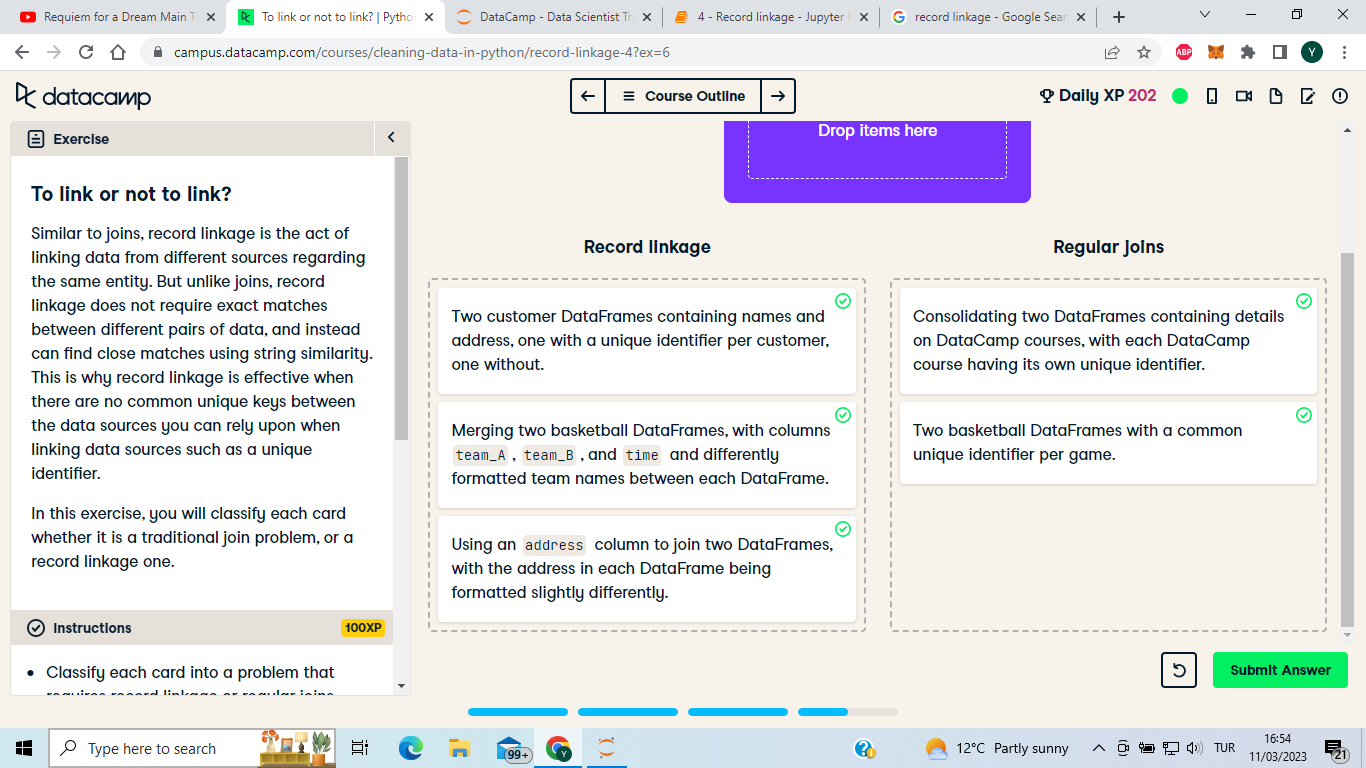

Fabulous! Don't make things more complicated than they need to be: record linkage is a powerful tool, but it's more complex than using a traditional join.

#### Pairs of restaurants
In the last lesson, you cleaned the restaurants dataset to make it ready for building a restaurants recommendation engine. You have a new DataFrame named restaurants_new with new restaurants to train your model on, that's been scraped from a new data source.

You've already cleaned the cuisine_type and city columns using the techniques learned throughout the course. However you saw duplicates with typos in restaurants names that require record linkage instead of joins with restaurants.

In this exercise, you will perform the first step in record linkage and generate possible pairs of rows between restaurants and restaurants_new. Both DataFrames, pandas and recordlinkage are in your environment.

In [6]:
import recordlinkage
import pandas as pd

restaurants_new = pd.read_csv("restaurants_L2_dirty.csv")

# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block("type")

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)

print(pairs)

MultiIndex([(  0,  0),
            (  0,  1),
            (  0,  7),
            (  0, 12),
            (  0, 13),
            (  0, 20),
            (  0, 27),
            (  0, 28),
            (  0, 39),
            (  0, 40),
            ...
            (221, 55),
            (230, 55),
            (233, 55),
            (238, 55),
            (241, 55),
            ( 40, 18),
            (281, 18),
            (288, 18),
            (302, 18),
            (308, 18)],
           length=3784)


#### Question
Now that you've generated your pairs, you've achieved the first step of record linkage. What are the steps remaining to link both restaurants DataFrames, and in what order?

<strong>a.Compare between columns, score the comparison, then link the DataFrames.</strong><br>
b.Clean the data, compare between columns, link the DataFrames, then score the comparison.<br>
c.Clean the data, compare between columns, score the comparison, then link the DataFrames<br>

Correct! In the next exercise, you will compare between columns and check out the matching potentially rows between both DataFrames!

#### Similar restaurants
In the last exercise, you generated pairs between restaurants and restaurants_new in an effort to cleanly merge both DataFrames using record linkage.

When performing record linkage, there are different types of matching you can perform between different columns of your DataFrames, including exact matches, string similarities, and more.

Now that your pairs have been generated and stored in pairs, you will find exact matches in the city and cuisine_type columns between each pair, and similar strings for each pair in the rest_name column. Both DataFrames, pandas and recordlinkage are in your environment.

In [7]:
# Create a comparison object
comp_cl = recordlinkage.Compare()

# Find exact matches on city, cuisine_types 
comp_cl.exact('city', 'city', label='city')
comp_cl.exact('type', 'type', label = 'type')

# Find similar matches of rest_name
comp_cl.string('name', 'name', label='name', threshold = 0.8) 

<Compare>

In [8]:
# Get potential matches and print
potential_matches = comp_cl.compute(pairs, restaurants, restaurants_new)
print(potential_matches)

        city  type  name
0   0      0     1   0.0
    1      0     1   0.0
    7      0     1   0.0
    12     0     1   0.0
    13     0     1   0.0
...      ...   ...   ...
40  18     0     1   0.0
281 18     0     1   0.0
288 18     0     1   0.0
302 18     0     1   0.0
308 18     0     1   0.0

[3784 rows x 3 columns]


In [9]:
potential_matches[potential_matches.sum(axis = 1) >= 3]

,,city,type,name
15,55,1,1,1.0


Print out potential_matches, the columns are the columns being compared, with values being 1 for a match, and 0 for not a match for each pair of rows in your DataFrames. To find potential matches, you need to find rows with more than matching value in a column. You can find them with<br>

potential_matches[potential_matches.sum(axis = 1) >= n]<br><br>
<strong>Question:</strong> Where n is the minimum number of columns you want matching to ensure a proper duplicate find, what do you think should the value of n be?


<strong>a.3 because I need to have matches in all my columns.</strong><br>
b.2 because matching on any of the 2 columns or more is enough to find potential duplicates.<br>
c.1 because matching on just 1 column like the restaurant name is enough to find potential duplicates.<br>

That's correct! For this example, tightening your selection criteria will ensure good duplicate finds! In the next lesson, you're gonna build on what you learned to link these two DataFrames!

#### Linking them together!
In the last lesson, you've finished the bulk of the work on your effort to link restaurants and restaurants_new. You've generated the different pairs of potentially matching rows, searched for exact matches between the cuisine_type and city columns, but compared for similar strings in the rest_name column. You stored the DataFrame containing the scores in potential_matches.

Now it's finally time to link both DataFrames. You will do so by first extracting all row indices of restaurants_new that are matching across the columns mentioned above from potential_matches. Then you will subset restaurants_new on these indices, then append the non-duplicate values to restaurants. All DataFrames are in your environment, alongside pandas imported as pd.

In [10]:
# Isolate potential matches with row sum >=3
matches = potential_matches[potential_matches.sum(axis = 1) >= 3]

# Get values of second column index of matches
matching_indices = matches.index.get_level_values(1)

# Subset restaurants_new based on non-duplicate values
non_dup = restaurants_new[~restaurants_new.index.isin(matching_indices)]

# Append non_dup to restaurants
full_restaurants = restaurants.append(non_dup)
print(full_restaurants)

   Unnamed: 0        name                       addr               city  \
0    american    american                   american           american   
1    american    american                   american           american   
2    american    american                   american           american   
3    american    american                   american           american   
4    american    american                   american           american   
..        ...         ...                        ...                ...   
77         77       feast        1949 westwood blvd.            west la   
78         78    mulberry        17040 ventura blvd.             encino   
79         79  matsuhissa   129 n. la cienega blvd.       beverly hills   
80         80     jiraffe      502 santa monica blvd       santa monica   
81         81    martha's  22nd street grill 25 22nd  st. hermosa beach   

         phone         type  
0     american     american  
1     american     american  
2     ame